Machine Learning Model for the Kaggle comptetition https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview 
This model ranked 2621 out of 4470 and is therefore in the 59th percentile.

The code for the display_all function and the code for the plot that shows how the number of estimators influence the model are copied from the machine learning course fast.ai
https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb
https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb

The Random Grid code is from 
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# imports

In [79]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display

from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# important functions

In [80]:
# Displays 1000 rows/columns of data
def display_all(df): 
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [81]:
# splits a dataset
def split_df(df, n):
    return df[:n], df[n:]

In [82]:
# Root Mean Squared Error
def RMSE(y_obs, y_pred): #observed vs predicted
    return math.sqrt((np.sum(np.power(np.add(y_obs, -y_pred),2)))/len(y_obs))

In [83]:
# print score, rmse on training and validation set
def print_score(m,df_1,y_1,df_2,y_2):
    result = [RMSE(m.predict(df_1),y_1), RMSE(m.predict(df_2),y_2), m.score(df_1,y_1), m.score(df_2,y_2)]
    if hasattr(m, 'oob_score_'): result.append(m.oob_score_)
    print(result)
def return_score(m,df_1,y_1,df_2,y_2):
    result = [RMSE(m.predict(df_1),y_1), RMSE(m.predict(df_2),y_2), m.score(df_1,y_1), m.score(df_2,y_2)]
    if hasattr(m, 'oob_score_'): result.append(m.oob_score_)
    return result

# Loading and displaying Training Data 

In [84]:
df_raw = pd.read_csv("data/house_price/train.csv", low_memory = False).drop("Id", axis=1)

# Data processing (log of dependent variable, change categorial variables to continues ones)

In [85]:
df_raw["SalePrice"] = np.log(df_raw["SalePrice"])

In [86]:
train_cats(df_raw) #string columns are now of type categorical

In [87]:
# create order of continues values where an order might be important
df_raw["LotShape"].cat.set_categories(["Reg","IR1","IR2","IR3"], ordered=True, inplace = True)
df_raw["LandContour"].cat.set_categories(["Lvl","Bnk","HLS","Low"], ordered=True, inplace = True)
df_raw["Utilities"].cat.set_categories(["AllPub","NoSewr","NoSeWa","ELO"], ordered=True, inplace = True)
df_raw["LandSlope"].cat.set_categories(["Gtl","Mod","Sev"], ordered=True, inplace = True)
df_raw["LotShape"].cat.set_categories(["Reg","IR1","IR2","IR3"], ordered=True, inplace = True)
df_raw["ExterQual"].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered=True, inplace = True)
df_raw["ExterCond"].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered=True, inplace = True)
df_raw["BsmtQual"].cat.set_categories(["Ex","Gd","TA","Fa","Po","NA"], ordered=True, inplace = True)
df_raw["BsmtCond"].cat.set_categories(["Ex","Gd","TA","Fa","Po","NA"], ordered=True, inplace = True)
df_raw["BsmtExposure"].cat.set_categories(["Gd","Av","Mn","No","NA"], ordered=True, inplace = True)
df_raw["BsmtFinType1"].cat.set_categories(["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"], ordered=True, inplace = True)
df_raw["BsmtFinType2"].cat.set_categories(["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"], ordered=True, inplace = True)
df_raw["HeatingQC"].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered=True, inplace = True)
df_raw["KitchenQual"].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered=True, inplace = True)
df_raw["Functional"].cat.set_categories(["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"], ordered=True, inplace = True)
df_raw["GarageFinish"].cat.set_categories(["Fin","RFn","Unf","NA"], ordered=True, inplace = True)
df_raw["GarageQual"].cat.set_categories(["Ex","Gd","TA","Fa","Po","NA"], ordered=True, inplace = True)
df_raw["GarageCond"].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered=True, inplace = True)
df_raw["PavedDrive"].cat.set_categories(["Y","P","N"], ordered=True, inplace = True)
df_raw["FireplaceQu"].cat.set_categories(["Ex","Gd","TA","Fa","Po","NA"], ordered = True, inplace = True)

# Missing values

In [88]:
df_raw.isnull().sum().sort_values(ascending = False).head(n=10)/len(df_raw)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageQual      0.055479
dtype: float64

In [89]:
df, y, nas = proc_df(df_raw, "SalePrice") #categorical values will be changed to continues values, independent variable split from df
df = df.drop(["LotFrontage_na","MasVnrArea_na","GarageYrBlt_na"], axis=1) #na columns create issues with the test set if there are no na in the same column
df = df.drop(["PoolQC","MiscFeature","Fence","Alley"], axis=1) #too many missing values

# Validation Set

In [90]:
df_train, df_val = split_df(df, len(df)-200)
y_train, y_val = split_df(y, len(df)-200)

# Hyperparameter tuning

In [91]:
n_estimators = [i for i in range(20,61,10)]
max_features = [1,0.5,"sqrt","log2"]
min_samples_leaf = [1,3,5,10,25] 
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

In [92]:
m = RandomForestRegressor()
m_random = RandomizedSearchCV(estimator = m, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=42, n_jobs = -1)
m_random.fit(df_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   12.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [20, 30, 40, 50, 60], 'max_features': [1, 0.5, 'sqrt', 'log2'], 'min_samples_leaf': [1, 3, 5, 10, 25], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [93]:
m_random.best_params_ #best parameter after 200 iteratons 3 folded

{'n_estimators': 40,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'bootstrap': False}

In [94]:
params = list(m_random.best_params_.values())

# RandomForest

In [95]:
#RandomForest with best parameter from the Random Grid
m = RandomForestRegressor(n_estimators = params[0], n_jobs = -1, min_samples_leaf = params[1], max_features = params[2], bootstrap = params[3]) 
m.fit(df_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [96]:
preds = np.stack([t.predict(df_val) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_val[0]

(array([12.19552, 12.08391, 12.07767, 12.10625, 12.06105, 12.08954, 12.10349, 12.10625, 12.12269, 12.15478,
        12.08108, 12.10016, 12.12811, 12.08954, 12.03765, 12.08954, 12.10625, 12.10625, 12.3194 , 12.12811,
        12.20607, 12.09514, 12.09486, 12.1442 , 12.03172, 12.12811, 12.05786, 12.20857, 12.29911, 12.08391,
        12.14153, 12.09458, 12.08954, 12.15478, 12.15478, 12.1335 , 12.12811, 12.10625, 12.1442 , 12.08954]),
 12.121839880730937,
 12.106252310247962)

[9.57654814861322e-06, 0.14185282883207556, 0.9999999994293229, 0.8672375825680922]


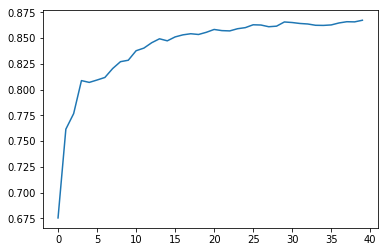

In [97]:
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(params[0])]); print_score(m,df_train,y_train,df_val,y_val)

# Test data set

In [98]:
df_test_raw = pd.read_csv("data/house_price/test.csv", low_memory = False).drop("Id", axis=1)

In [99]:
apply_cats(df_test_raw, df_raw) #string columns are now of type categorical, but uses the same template from train_cats

In [100]:
cols = ['BsmtFinSF1_na','BsmtFinSF2_na','BsmtUnfSF_na','TotalBsmtSF_na','BsmtFullBath_na','BsmtHalfBath_na','GarageCars_na','GarageArea_na',"LotFrontage_na","MasVnrArea_na","GarageYrBlt_na","Alley","Fence","PoolQC","MiscFeature"]
df_test = proc_df(df_test_raw)[0].drop(cols, axis=1)

In [101]:
y_test = m.predict(df_test)

In [102]:
df_sub=pd.DataFrame({'Id':np.array(df_test_raw.index) + 1461, 'Saleprice':np.exp(y_test)})


In [103]:
df_sub.to_csv("house_price_test.csv", index=False)